In [117]:
from dasquakes import *
import datetime
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'obspy'

In [58]:
cable='seadasn'
record_length = 1 #minutes
t0 = datetime.datetime(2022, 5, 8, 0, 2, 0)

In [59]:
prefix, network_name, datastore = data_wrangler(cable,record_length,t0)

data,dates,attrs = open_sintela_file(prefix,
                                     UTCDateTime(t0),
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=False)

In [70]:
nt = data.shape[0]
nx = data.shape[1]
print(f'Number of time steps: {nt}, Number of channels: {nx}')
print (f"Nyquist Frequency: {attrs['MaximumFrequency']} Hz, cable length: {attrs['SpatialSamplingInterval']*nx} m")

Number of time steps: 6000, Number of channels: 1749
Nyquist Frequency: 50.0 Hz, cable length: 11160.285674571991 m


In [71]:
start_cha = 800#350
end_cha = 1300#data.shape[1]#500

In [72]:
# nx = attrs['SpatialSamplingInterval']*(end_cha-start_cha)

Text(0.5, 0, 'Raw Amplitude')

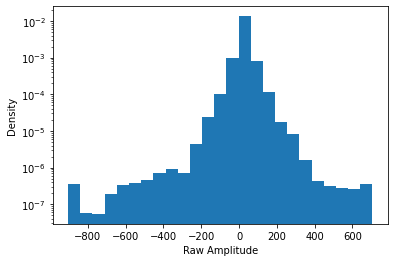

In [46]:
flat_data = data.flatten()
plt.hist(flat_data, bins=25, density=True)
plt.yscale('log')
plt.ylabel('Density')
plt.xlabel('Raw Amplitude')

In [63]:
data_select = data[:,start_cha:end_cha]

In [64]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
# filter in time
[b,a]=butter(2,1,'lowpass', fs=100)
data_filt = filtfilt(b,a,data_select,axis=0)

#filter in space
[b,a]=butter(2,1/(100),'lowpass', fs=1/attrs['SpatialSamplingInterval'])
data_filt = filtfilt(b,a,data_filt,axis=1)


In [65]:
data_white = data_filt / np.mean(data_filt, axis=0)[None,:]

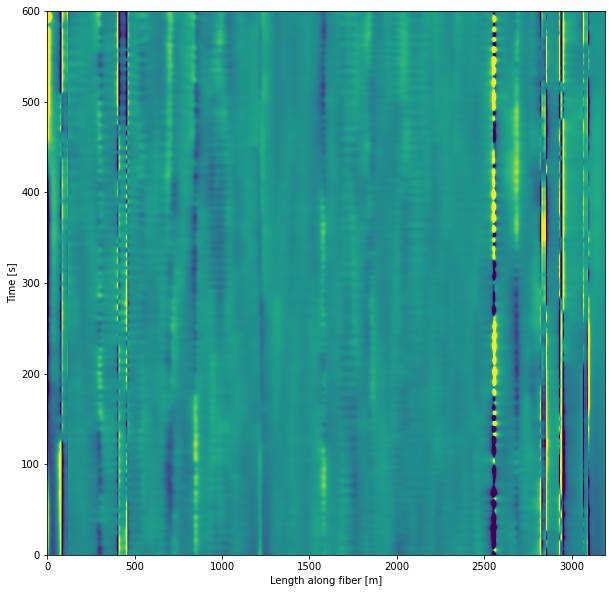

In [66]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,10))
plt.imshow(data_white, #np.log(np.abs(data_white)),
           aspect='auto',vmin=np.percentile(data_white,1),vmax=np.percentile(data_white,99),
           extent=[0,nx,0,nt/attrs['PulseRate']*10]
                )
plt.xlabel('Length along fiber [m]')
plt.ylabel('Time [s]')
plt.show()

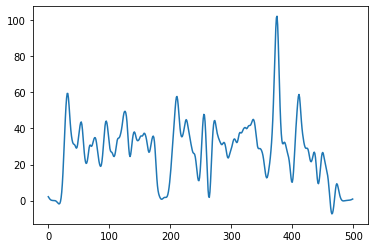

In [36]:
plt.plot(np.mean(data_filt, axis=0))

In [79]:
start_cha = 350
end_cha = 800
data_select = data[:,start_cha:end_cha]

In [81]:
# calculate the displacement for each channel
displs = np.cumsum(np.cumsum(data_select, axis=0), axis=0)

In [82]:
np.shape(displs)

(6000, 450)

In [86]:
attrs

{'AcquisitionId': b'140e7cf0-6a8e-4029-8d24-7b6095ce22da',
 'Build': b'release-5.17:9_P',
 'Classification': b'TestClass',
 'Comment': b'TestComment',
 'CommitHash': b'f9dcdb09c',
 'Creator': b'TestAuthor',
 'DasInstrumentBox': b'ONYX',
 'DetectionAccuracy': b'Incorrect Classification',
 'FFID': 0,
 'FacilityId': b'ONYX-0203 Fiber 1',
 'FiberID': 0,
 'GaugeLength': 6.38095235824585,
 'GaugeLengthUnit': b'm',
 'Hostname': b'ONYX-0203',
 'MaximumFrequency': 50.0,
 'MeasurementStartTime': b'2022-05-08T00:01:59.997000+00:00',
 'MinimumFrequency': 0.0,
 'NumberOfLoci': 1750,
 'OpticalPath': b'OpticalPath',
 'PulseRate': 100.0,
 'PulseRateUnit': b'Hz',
 'PulseWidth': 20.0,
 'PulseWidthUnit': b'ns',
 'SoftwareVersion': b'9',
 'SpatialSamplingInterval': 6.38095235824585,
 'SpatialSamplingIntervalUnit': b'm',
 'StartLocusIndex': 0,
 'SystemType': b'Xavier',
 'TriggeredMeasurement': 0,
 'VendorCode': b'Sintela',
 'schemaVersion': b'2.0',
 'uuid': b'94de827a-8317-4f6c-a156-ae4895331e3a'}

In [87]:
n_cha = end_cha-start_cha
fs = attrs['PulseRate']
t = data.shape[0]/fs

Text(0.5, 0, 'Time [s]')

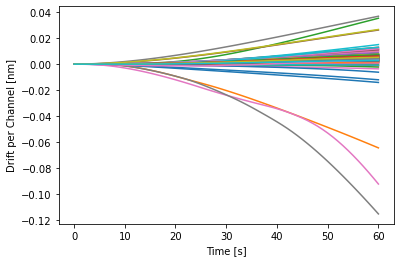

In [92]:
# plot displacement per channel over time
for i in range(n_cha):
    plt.plot(np.arange(0,t+1),displs[::int(fs)-1,i]/1e9)
plt.ylabel('Drift per Channel [nm]')
plt.xlabel('Time [s]')

Text(0.5, 0, 'Time [s]')

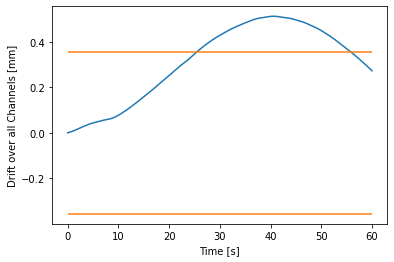

In [102]:
# plot displacement integrated over the entire cable
displ_int = np.cumsum(np.sum(data_select, axis=1)) # displacement over the entire cable
plt.plot(np.arange(0,t,1/fs), displ_int*1e-9*1e3)
displ_rms = np.sqrt(np.mean(displ_int**2))
plt.hlines(np.array([-displ_rms, displ_rms])*1e-9*1e3, 0,t, color='C1')
plt.ylabel('Drift over all Channels [mm]')
plt.xlabel('Time [s]')

In [106]:
print(r'Drift expected to measure after {}sec: {:.3f} micon'.format(t, displ_rms*1e6*1e-9))

Drift expected to measure after 60.0sec: 356.062 micon


Text(0.5, 0, 'Time [s]')

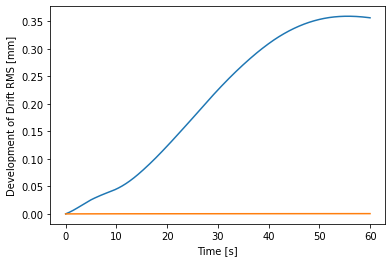

In [114]:
unc = 1e-9 # DAS uncertainty

plt.plot(np.arange(0,t,1/fs), 
         np.sqrt(np.cumsum(displ_int**2)/np.arange(1,len(displ_int)+1))*1e3*1e-9)
plt.plot(np.arange(0,t,1/fs), 
         np.sqrt(np.arange(1,len(displ_int)+1))*unc*0.32*np.sqrt(n_cha)*1e3) # 0.32 comes from 1 sigma
plt.ylabel('Development of Drift RMS [mm]')
plt.xlabel('Time [s]')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Text(0.5, 0, 'Time [s]')

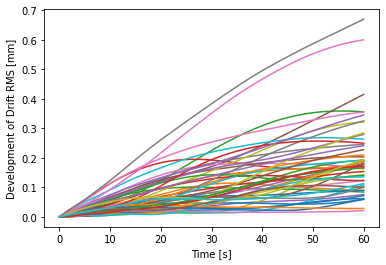

In [168]:
# run this for some minutes

cable='seadasn'
record_length = 1 #minutes
t0 = datetime.datetime(2022, 5, 8, 0, 0, 0)

start_cha = 350
end_cha = 800

n_loops = 50

rms_arr = np.full((n_loops,6000),np.nan)

for i in range(n_loops):
    print(i)
    prefix, network_name, datastore = data_wrangler(cable,record_length,t0)

    data,dates,attrs = open_sintela_file(prefix,
                                     t0+datetime.timedelta(minutes=i),
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=False)
    
    data_select = data[:,start_cha:end_cha]
    
    displ_int = np.cumsum(np.sum(data_select*1e-9, axis=1)) # displacement over the entire cable
    rms_func = np.sqrt(np.cumsum(displ_int**2)/np.arange(1,len(displ_int)+1))
    plt.plot(np.arange(0,t,1/fs), 
         rms_func*1e3)
    rms_arr[i,:] = rms_func
# plt.plot(np.arange(0,t,1/fs), 
#          np.sqrt(np.arange(1,len(displ_int)+1))*unc*0.32*np.sqrt(n_cha)*1e3,
#         color='r', linewidth=2.5) # 0.32 comes from 1 sigma
plt.ylabel('Development of Drift RMS [mm]')
plt.xlabel('Time [s]')

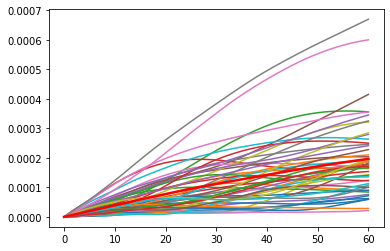

In [171]:
for i in range(np.shape(rms_arr)[0]):
    plt.plot(np.arange(0,t,1/fs), rms_arr[i])
plt.plot(np.arange(0,t,1/fs), np.mean(rms_arr, axis=0), color='r', linewidth=2.5)
# plt.plot(np.arange(0,t,1/fs), np.sqrt(np.arange(0,t,1/fs)/1e3/2), color='blue', linewidth=2.5)